# IndiaSim ABM

In [189]:
#import Pkg # for installing packages/package manager
## get packages that are necessary or install them if they don't exist in the current environment
#Pkg.add(["Agents", "Random", "DataFrames", "Distributions", "DrWatson", "Plots","StatsBase",
# "CSV", "DataStructures"])

In [190]:
using Agents, Random, DataFrames, CSV, DataStructures
using Distributions
using DrWatson: @dict
using Plots

In [191]:
#Below function is used to model the transmission rate that decreases by an exponential scale nearing the end of the
    #infection period
function exponential_decay(first,last,steps)
    multiplicative_factor=(last/first)^(1/steps)    
    return multiplicative_factor.^(1:steps).*first
end


exponential_decay (generic function with 1 method)

In [192]:
#Sample individual reproductive number using geometric distribution
function R_distribution(age,mean_R0,Fi_vals,state,district,mean_Fi)
    #println(Fi_vals[age+1])
    r_val=0
    try
        r_val=rand(Geometric(1 -Fi_vals[age+1]))+1 * mean_R0
    catch
        #Exception thrown when the agent will have Fi=0. This is because there are no other agents
            #in the district. We assign agent a reproductive number of 0.
        println("Isolated Agent:")
        println(state,district,Fi_vals,Fi_vals[age+1])
    end
    #println("r_val ",r_val)
    return r_val
end

R_distribution (generic function with 1 method)

In [193]:
#Sample individual reproductive number using Fi distribution
function R_distribution(age,mean_R0,Fi_vals,state,district,mean_Fi)
    #println(Fi_vals[age+1])
    Fi_val=Fi_vals[age+1]
    if Fi_val<0
        Fi_val=0
    end
    r_val=Fi_val/(mean_Fi)*mean_R0
    #println("r_val ",r_val)
    #println("Fi:",Fi_val," mean Fi:",mean_Fi," ReprodNum:",r_val)
    return r_val
end

R_distribution (generic function with 1 method)

In [194]:
#Next function is the distributions of vaccine efficacy for agent sampling

vaccine_efficacy_low_bound=0.63
vaccine_efficacy_up_bound=0.89

function vaccine_efficacy_dist(lower=vaccine_efficacy_low_bound,upper=vaccine_efficacy_up_bound)
    return rand(Uniform(lower,upper))
end

antibiotics_vaccination_df = DataFrame(CSV.File("antibiotics_childhood_vaccination.csv"))
under_two_vaccination_abx=antibiotics_vaccination_df[isequal.(antibiotics_vaccination_df[!,"Vaccine"],"PCV") .& isequal.(antibiotics_vaccination_df[!,"Age group (months)"],"0-23").& isequal.(antibiotics_vaccination_df[!,"Outcome against which Protection is Evaluated"],"ARI"),"Estimated VE"][[1,3]] # new data frame
two_to_five_vaccination_abx=antibiotics_vaccination_df[isequal.(antibiotics_vaccination_df[!,"Vaccine"],"PCV") .& isequal.(antibiotics_vaccination_df[!,"Age group (months)"],"24-59").& isequal.(antibiotics_vaccination_df[!,"Outcome against which Protection is Evaluated"],"ARI"),"Estimated VE"][[1,3]] # new data frame
five_plus_vaccination_abx=antibiotics_vaccination_df[isequal.(antibiotics_vaccination_df[!,"Vaccine"],"PCV") .& isequal.(antibiotics_vaccination_df[!,"Age group (months)"],"24-59").& isequal.(antibiotics_vaccination_df[!,"Outcome against which Protection is Evaluated"],"ARI"),"Estimated VE"][[1,3]] # new data frame
five_plus_factor=(five_plus_vaccination_abx[2]-five_plus_vaccination_abx[1])/2
five_plus_vaccination_abx[1]-=five_plus_factor
five_plus_vaccination_abx[2]+=five_plus_factor

#This function uses agent age and reproductive number; it calculates tranmission rate by day for each day of infection.
    #It also determines whether the agent will die, and days of infection until death if so, and whether the agent
    #will take antibiotics, and the day if so.
function transmission_rate(age, wealth, vaccine_efficacy, R0_mean, Fi_vals,state,district, mean_Fi,days_incubate=rand(1:3),days_increase=rand(1:5),
    days_decrease_linear=rand(3:9), days_decrease_exponential=rand(5:25))   
    
    #Scaling the reproductive number based on differential # of contacts by age
    #scales mean R0 by total contacts given agent age using gamma distribution sampling
    reproductive_number=R_distribution(age,R0_mean,Fi_vals,state,district,mean_Fi)    
    
    if age<5#carriage rate data from https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0246522&type=printable
        
        if age<2
            if age<1
                carriage_prob=0.152
            else
                carriage_prob = 0.019
            end
        else
            carriage_prob=0.004
        end
    else
        carriage_prob=0
    end
    
    carrier = false
    #Below if statement determines whether agent is a carrier and will have the transmissible infection for a 
        #prolongued period of time
    
    
    #This is the transmission rate if the agent is not a carrier, adding additional transmission days in if statement below 
            #if agent is a carrier  
    
    days_carrier=0
    
    if rand(Uniform(0,1))<carriage_prob
        days_carrier = trunc(Int,round(1/(rand(Uniform(0.64,0.75))/30)))-(days_increase+days_decrease_linear+days_decrease_exponential) 
        carrier = true
        #monthly carriage clearance data from https://doi.org/10.1186/1471-2334-9-102. Accounting for all other days of infection
        #that technically count as carriage (aside from incubation period)
        
        #If a carrier, the reproductive number is 1 over the remaining days of carriage (note the 1/days_carrier)
    end
    
    transmission_scale = Vector{Float64}(undef,days_incubate+days_increase+days_decrease_linear+days_decrease_exponential+days_carrier)
    
    trans_index=1
    
    for i in zeros(days_incubate)
        transmission_scale[trans_index]=i
        trans_index+=1
    end   
        
    if days_increase<2
        transmission_scale[trans_index]=1
        trans_index+=1

    else
        for i in LinRange(0,1,days_increase+1)[2:days_increase+1] #Need to add 1 to function because LinRange adds 0 as first value, then index 2: to remove 0
            transmission_scale[trans_index]=i
            trans_index+=1
        end
    end
    
    if days_decrease_linear<2
        transmission_scale[trans_index]=rand(Uniform(1/3,2/3))
        trans_index+=1
    else
        for i in LinRange(1,rand(Uniform(1/3,2/3)),days_decrease_linear+1)[2:days_decrease_linear+1] #Need to add 1 to function because LinRange adds 0 as first value, then index 2: to remove 0
            transmission_scale[trans_index]=i
            trans_index+=1
        end
    end

    for i in exponential_decay(transmission_scale[trans_index-1],rand(Uniform(1/100,1/5)),days_decrease_exponential)
        transmission_scale[trans_index]=i
        trans_index+=1
    end 
    
    transmission_scale=transmission_scale.*(reproductive_number/sum(transmission_scale[1:trans_index-1]))
    
    if days_carrier>0
        for i in repeat([1/days_carrier],days_carrier)
            transmission_scale[trans_index]=i
            trans_index+=1
        end 
    end  
    
    #default is no antibiotics; if agent is not a carrier, will seek antibiotics. Chance of seeking antibiotics if vaccinated
    days_till_antibiotic=-1
    
    if carrier==false #If not carrier, agent will seek antibiotics 1-5 days after onset of symptoms
        if vaccine_efficacy>0 #If vaccinated, transmission rate and death probability are reduced; below is also
                                #the probability they will seek antibiotics (based on age)
            transmission_scale.*0.75 #reduced transmission rate by arbitrary 25%
            
            if age<2
                if age<1 #if 0-1 yrs old
                    #Accounting for the -0.066 in the CI of -0.066 to 0.19
                    if vaccine_efficacy<vaccine_efficacy_low_bound+
                            (vaccine_efficacy_up_bound-vaccine_efficacy_low_bound)*abs(under_two_vaccination_abx[1])/
                        (abs(under_two_vaccination_abx[1])+under_two_vaccination_abx[2])
                        days_till_antibiotic=days_incubate + rand(1:5)

                    elseif rand(Uniform(0,1))> rand(Uniform(under_two_vaccination_abx[1],under_two_vaccination_abx[2]))#Probability sourced from:https://www.nature.com/articles/s41586-020-2238-4 (Roughly symmetric CIs)
                        days_till_antibiotic=days_incubate + rand(1:5)
                    end
                
                    #if 2-5 years old
                
                elseif rand(Uniform(0,1))> rand(Uniform(two_to_five_vaccination_abx[1],two_to_five_vaccination_abx[2])) 
                        days_till_antibiotic=days_incubate + rand(1:5)
                end
            #if 5+ years old
            elseif vaccine_efficacy<vaccine_efficacy_low_bound+ #Accounting for negative lower bound here as well
                            (vaccine_efficacy_up_bound-vaccine_efficacy_low_bound)*abs(five_plus_vaccination_abx[1])/
                        (abs(five_plus_vaccination_abx[1])+five_plus_vaccination_abx[2])
                
            elseif rand(Uniform(0,1))> rand(Uniform(five_plus_vaccination_abx[1],five_plus_vaccination_abx[2]))#Probability sourced from:https://www.nature.com/articles/s41586-020-2238-4 (Roughly symmetric CIs)
                        days_till_antibiotic=days_incubate + rand(1:5)

            end
        
        else #if not vaccinated, seek antibiotics according to wealth quintile
            
            if wealth<5
                antibiotics_outcome = rand(Uniform(0,1))
                
                #Below if statement: agent has variable probability to be administered antibiotics based on wealth quintile
                
                if (wealth==4 && antibiotics_outcome<0.95) || (wealth==3 && antibiotics_outcome<0.8) || 
                    (wealth==2 && antibiotics_outcome<0.6) || (wealth==1 && antibiotics_outcome<0.2)
                    
                    days_till_antibiotic=days_incubate + rand(1:5)
                end
                                    
            else #if wealth quintile 5, seek antibiotics, always
                days_till_antibiotic=days_incubate + rand(1:5)
            end
        end
    end
        
            
    if age>5 #Death probability from: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3167921/
        death_prob =0.041333
    else
        death_prob = 0.04247
    end
    
    #vaccinated arbitrarily die at 75% of probability of unvaccinated, 0% probability if they don't seek antibiotics
    if vaccine_efficacy>0 
        if days_till_antibiotic != -1
            death_prob*=0.75 
        else
            death_prob=0
        end
    end
                
    
    if rand(Uniform(0,1))<death_prob
        days_till_death= days_incubate+rand(10:30) #data according to the bacterial kinetics model and https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3167921/pdf/793.pdf
    else
        days_till_death=-1 #agent will not die
    end
    
    #With current parameters, infection period lasts anywhere between 10-50 days
    return [transmission_scale,days_till_death,days_till_antibiotic]
end

transmission_rate (generic function with 5 methods)

In [195]:
transmission_sample=zeros(10^6)

for i in 1:10^6
    transmission_sample[i]=length(transmission_rate(rand(0:12), rand(1:5), NaN, NaN, repeat([NaN],13),"NaN","NaN", NaN)[1])
end

        
avg_transmission_duration=mean(transmission_sample)

26.263762

In [196]:
# @agent PoorSoul GraphAgent begin # then can drop the pos

mutable struct PoorSoul <: AbstractAgent 
    id::Int
    day_of_infection::Int  # How far along infection a sick individual is (accelerated w/ antibiotics)
    days_infected::Int #Number of agent has been sick
    status::Symbol
    ever_infected::Bool #Whether agent has ever been infected
    transmission::Array{Float64,1} #Agent-level tranmission for each of the the days agent is infected.
    vaccine_efficacy::Float64 #Probability for successfully transmitted disease to infect the agent is 1-vaccine_efficacy
    days_till_death::Int #Either an integer of the days infected until death, or "-1" if agent won't die.
                            #assigned at start of simulation, probability given by proportion of infected that die when sick. 
    days_till_antibiotic::Int #Either an integer of the # of days into infected until an agent seeks antibiotics, or "-1"
                                #if the agent will not be seeking antibiotics (will not be seeking if agent is not
                                #infected or if the agent has been infected and is treated with effective antibiotics)
    
    antibiotics_treated_with::Array{String,1} #The antibiotics a currently-infected agent has tried
    
    serotype_immunity::Array{Int,1} #Contains the serotypes the agent has been infected with and is now immune to.
    
    high_prev_serotype::Bool #Whether or not agent was ever infected by one of serotypes 1-32. We record this to
                                #simplify computations for reinfection probability
    age_cat::Int
    days_age_cat::Int #Days passed as agent is in the same age category (every 365 days, age incremented by one) 
    wealth_cat::Int
    state::String
    district::Int
    serotype::Int
end

In [197]:
# parameters for the transmission of the infection
# the key idea is to have a modular design so that we can easily flip and flip out new pathogens
function model_initiation(;
    R0_mean,
    vaccine_efficacy_distribution,
    serotypes,
    serotype_prevalence,
    states_districts,
    district_growth_rate,
    daily_growth,
    states_districts_pop,
    states_districts_info,
    ids_states_districts,
    state_vacc_info,
    state_spneumoniae_prevalence,
    seed =1111322,
)

    
    rng = MersenneTwister(seed)
    
    #killed_agents = Int[] #Gather the position IDs of dead agents by district 
    
    pop_by_state = Dict{String,Int}() #Monitor population by state every step
    cases_by_state = Dict{String,Int}() #Monitor cases by state every step
    prop_infected_by_state = Dict{String,Float64}() #Monitor proportion infected every step
    
    N_total=0
    for state in keys(states_districts)
        for district in states_districts[state]
            N_total+=states_districts_pop[(state,district)]
        end
    end
    
    avg_transmission_by_state=Dict{String,Float64}() #The average transmission rate of infected by state for the current day
    antibiotics_by_day=Int[0]
    cumulative_deaths=Int[0]
    step=1
    community_transmitted=0 #recording to analyze dynamics
    contact_transmitted=0 #recording to analyze dynamics
    
    
    states_districts_contact_matrices =Dict{Tuple{String,Int},Matrix{Float64}}()
    
    available_ages_states_districts = Dict{Tuple{String,Int},Vector{Int64}}()
    
    states_districts_ages_ids = DefaultDict{Tuple{String,Int},Dict{Int64,Vector{Int64}}}(()->Dict{}())
    
    deaths_by_district_step = Dict{Tuple{String,Int},Int64}()
    
    replace_unvac_by_district_step = Dict{Tuple{String,Int},Int64}()

    replace_vac_by_district_step = Dict{Tuple{String,Int},Int64}()
    
    
    total_agents_ever_added_naturally=Dict{Tuple{String,Int},Int}()
    
    mean_Fi=0
    
    vaccination_scale_factor=0
    
    agents_to_add_total_natural=0
    agents_to_add_total_vac=0
    agents_to_add_total_unvac=0
    
    total_quintiles=Vector{Int}[[0],[0],[0],[0],[0]]
    infections_quintiles=Vector{Int}[[0],[0],[0],[0],[0]]
    antibiotics_quintiles=Vector{Int}[[0],[0],[0],[0],[0]]
    cumulative_deaths_quintiles=Vector{Int}[[0],[0],[0],[0],[0]]
    
    total_added_naturally_per_state = Dict{String,Int64}()
    total_ever_cases_per_state = Dict{String,Int64}()
    total_ever_abx_per_state= Dict{String,Int64}()
    
    infection_duration = Int[]
    
    properties = @dict(
    pop_by_state,
    cases_by_state,
    prop_infected_by_state,
    R0_mean,
    vaccine_efficacy_distribution,
    #killed_agents,
    state_spneumoniae_prevalence,
    serotypes,
    serotype_prevalence,
    states_districts,
    states_districts_pop,
    states_districts_info,
    ids_states_districts,
    states_districts_ages_ids,
    avg_transmission_by_state,
    antibiotics_by_day,
    cumulative_deaths,
    community_transmitted,
    contact_transmitted,
    available_ages_states_districts,
    step,
    state_vacc_info,
    vaccination_scale_factor,
    district_growth_rate,
    daily_growth,
    deaths_by_district_step,
    replace_unvac_by_district_step,
    replace_vac_by_district_step,
    states_districts_contact_matrices,
    total_agents_ever_added_naturally,
    mean_Fi,
    N_total,
    agents_to_add_total_natural,
    agents_to_add_total_vac,
    agents_to_add_total_unvac,
    total_quintiles,
    infections_quintiles,
    antibiotics_quintiles,
    cumulative_deaths_quintiles,
    total_added_naturally_per_state,
    total_ever_cases_per_state,
    total_ever_abx_per_state,
    infection_duration
    )
    
    model = ABM(PoorSoul; properties, rng)
    
    tot_each_age=Dict{Int,Int}()
    for age in 0:12
        tot_each_age[age]=0
    end
 
    
    #Predefining age distributions by district
    ages=Int[]
    for state in keys(states_districts)
        
        #Recording incidence of disease by state
        cases_by_state[state]=0
        pop_by_state[state]=0
        
        state_transmissions=Float64[]
        
        
        for district in states_districts[state]
            
            index_age=1
            
            try
                ages_district=Vector{Int}(undef,states_districts_pop[(state,district)])

            
                poss_ages,age_props=0:12,states_districts_info[(state,district)]["proportion_pop_by_age"]

                for n in 1:states_districts_pop[(state,district)]
                    
                    age_cat = poss_ages[rand(DiscreteNonParametric(1:13,age_props))]
                    ages_district[index_age]=age_cat
                    tot_each_age[age_cat]+=1
                    
                    index_age += 1
                end
                append!(ages,ages_district)
            catch #if population is 0
            end
        end
    end
    
    
    tot_Fi_vals=Float64[]
    
    #Generating contact matrices using pre-defined ages
    for state in keys(states_districts)
                
        for district in states_districts[state]
            
            contact_matrix=zeros(13,13)           
            
            #println(state,district,states_districts_info[(state,district)]["proportion_pop_by_age"])
            for age1 in 1:13
                for age2 in 1:13
                    N_total=states_districts_pop[(state,district)]
                    
                    #contact matrix is computed using same formula as F matrix from https://www.nature.com/articles/s41467-020-20544-y
                    val= (((N_total*states_districts_info[(state,district)]["proportion_pop_by_age"][age1])*
                            (N_total*states_districts_info[(state,district)]["proportion_pop_by_age"][age2]-
                                kronecker_delta(age1,age2)))/(N_total-1))/(tot_each_age[age1-1])
                    
                    #println(state,district,"&",N_total-1, "&",tot_each_age[age1-1])
                    #println(val)
                    if isnan(val)#If no agents of an age
                        contact_matrix[age1, age2] =0
                    elseif val>0
                        contact_matrix[age1, age2] =val
                    else #sometimes computed value is has a very small magnitude below 0.
                        contact_matrix[age1, age2] =0
                    end
                end
            end
      
       
            #Adding Fi_vals specific to district
            #Fi: probability for an agent of each age to contact any one individual (in chronological order by age)
            Fi_vals=Vector{Float64}(undef,13) #probability for an agent of each age to contact any one individual (in chronological order by age)

            for agei in 1:13
                Fi=0
                for age_contacted in 1:13
                    Fi+=contact_matrix[age_contacted,agei]*
                    (states_districts_info[(state,district)]["proportion_pop_by_age"][age_contacted])
                end
                if Fi<1
                    Fi_vals[agei]=Fi
                else
                    Fi_vals[agei]=0.9999 #Just a safety measure for p if it ends up at 1
                end
            end
            
            #println(Fi_vals)
            states_districts_info[(state,district)]["Fi_vals"]=Fi_vals
            
            # normalize migration_rates
            contact_matrix_sum = sum(contact_matrix, dims = 1)
            for c in 1:13 
                contact_matrix[:, c] ./= contact_matrix_sum[c]
            end
                    
            #Adding contact matrices specific to districts to separate data structure
            states_districts_contact_matrices[state,district]=contact_matrix
            
        end
    end
    
    agent_id=1
    for state in keys(states_districts)        
        
        for district in states_districts[state]
            
 

            for n in 1:states_districts_pop[(state,district)]
                
                push!(tot_Fi_vals,states_districts_info[(state,district)]["Fi_vals"][ages[agent_id]+1])
                
            end
        end
    end
    
    model.mean_Fi=mean(tot_Fi_vals)

    
    #adding agents in by district
    agent_id=1
    for state in keys(states_districts)
        
        #Recording incidence of disease by state
        cases_by_state[state]=0
        pop_by_state[state]=0
        
        state_transmissions=Float64[]
                    
        total_added_naturally_per_state[state]=0
        total_ever_cases_per_state[state]=0
        total_ever_abx_per_state[state]=0
        
        for district in states_districts[state]
            
            
            total_agents_ever_added_naturally[(state,district)]=0
            
            poss_wealth,wealth_props=1:5,states_districts_info[(state,district)]["proportion_pop_by_wealth"]
            
            for age_category in 0:12
                states_districts_ages_ids[(state,district)][age_category] = []
            end
            
            for n in 1:states_districts_pop[(state,district)]
                
                
                
                push!(ids_states_districts[(state,district)],agent_id)

                
                wealth_cat=poss_wealth[rand(DiscreteNonParametric(1:5,wealth_props))]
                
                age_cat=ages[agent_id]
                
                days_age_cat = rand(1:364)
                
                
                total_agents_ever_added_naturally[(state,district)]+=1
                
                                    
                push!(states_districts_ages_ids[(state,district)][age_cat],agent_id)
                
                agent_id+=1
                
                pop_by_state[state]+=1
                
                vaccine_efficacy= 0 #In this version of the model, no agents are vaccinated at start
                
                model.total_quintiles[wealth_cat][model.step]+=1
                            
                if rand(rng) <= state_spneumoniae_prevalence[state]   #if sick
                    cases_by_state[state]+=1     
                    
                    #assigned serotype agent is infected with
                    serotype=rand(DiscreteNonParametric(serotypes,serotype_prevalence)) 
                                        
                    if serotype in 1:32 #Whether or not agent has been infected with a high-prevalence serotype
                        high_prev_serotype=true
                    else
                        high_prev_serotype=false
                    end
                                          
                    #agent transmission rate, days until death, whether agent is a carrier
                    transmission_by_day,days_till_death,days_till_antibiotic=transmission_rate(age_cat,wealth_cat,
                        vaccine_efficacy,R0_mean,states_districts_info[(state,district)]["Fi_vals"],state,district,model.mean_Fi) 
                    
                    push!(state_transmissions,transmission_by_day[1])
                    
                    serotype_immunity = Vector{Int}(undef,112)
                    serotype_immunity[serotype]=serotype
                    
                    ind = add_agent!(model,1,1,:I,true,transmission_by_day,vaccine_efficacy,
                        days_till_death,days_till_antibiotic,String[],serotype_immunity,high_prev_serotype,age_cat,days_age_cat,wealth_cat,state,district,serotype)
                    
                    model.infections_quintiles[wealth_cat][model.step]+=1
                    
                    model.total_ever_cases_per_state[state]+=1
                    
                    
                else #if healthy
    

                    ind = add_agent!(model,0,0,:S,false,Float64[],vaccine_efficacy,-1,-1,
                    String[],Vector{Int}(undef,112),false,age_cat,days_age_cat,wealth_cat,state,district,0)
                end
            end
        end
         

        prop_infected_by_state[state] = cases_by_state[state]/pop_by_state[state]
        try
            avg_transmission_by_state[state]=sum(state_transmissions)/length(state_transmissions)
        catch
            avg_transmission_by_state[state]=0 #(pop in state is 0)
        end
    end
    

    
    return model
end

model_initiation (generic function with 1 method)

In [198]:
function kronecker_delta(i,j)
    i==j && return 1
    return 0
end

kronecker_delta (generic function with 1 method)

In [199]:
function create_params(;
    total_agents=150000, #Total agents in the model
    R0_mean=1.1,#average reproductive number of the disease
    vaccine_efficacy_distribution = vaccine_efficacy_dist, #Distribution of vaccine efficacy on agent basis
    serotypes=1:112,
    serotype_prevalence=append!(repeat([0.8/32],32),repeat([0.2/(112-32)],112-32)), #Prevalence of the serotypes in the serotypes array (chronological order)
    states_districts=Dict{String,Vector{Int}}(),
    states_districts_info = DefaultDict{Tuple{String,Int},Dict{String,Vector{Float64}}}(()->Dict{}()),
        #Contact matrices in separate data structure so that the different array types can be specified 
        #for most efficient computing
    states_districts_pop=Dict{Tuple{String,Int},Int}(), #Integer of population by state
    ids_states_districts = Dict{Tuple{String,Int},Vector{Int}}(), #How we determine id of agents that may be infected, given their position in contact matrix 
    state_vacc_info=Dict{String,Vector{Float64}}(), #proportion vaccinate by wealth in order 1,2,3,4,5
    state_spneumoniae_prevalence=Dict{String,Float64}(), #Incidence of S. pneumoniae by Indian state
    seed = 25,
        
)
    
    wealthq_by_district_df = DataFrame(CSV.File("wealthq_data_condensed.csv"))
    quintile_probs = [Matrix(wealthq_by_district_df)[i,:][3:7] for i in 1:length(Matrix(wealthq_by_district_df)[:,1])]
    num_districts_by_state = Dict{String,Int}()

    vaccination_df = DataFrame(CSV.File("vaccination_data_condensed.csv"))
    incidence_by_state_df = DataFrame(CSV.File("s.pneumoniae_incidence_estimates.csv"))

    #Filling up states_districts dict, proportion_pop_by_wealth
    for state in Set(wealthq_by_district_df.state_name)
        num_districts_by_state[state]=0
        for district in wealthq_by_district_df[isequal.(wealthq_by_district_df[!,"state_name"],state),"district_no"]        
            try
                    states_districts[state]=push!(states_districts[state],district)
            catch 
                    states_districts[state]=[district]
            end
            num_districts_by_state[state]+=1
            
            states_districts_info[(state,district)]["proportion_pop_by_wealth"]=quintile_probs[district]
            
        end
    end
    
    for state in keys(states_districts)
        state_vacc_info[state]= vec(Array{Float64}(vaccination_df[isequal.(vaccination_df[!,"state_name"],state),["vaccinate_wealthq_1","vaccinate_wealthq_2","vaccinate_wealthq_3","vaccinate_wealthq_4","vaccinate_wealthq_5"]]))
        

        
        if state in incidence_by_state_df[!,"Indian State"]
            state_spneumoniae_prevalence[state]=parse(Float64,split(incidence_by_state_df[isequal.(incidence_by_state_df[!,"Indian State"],state),["Pneumococcal Pneumonia Episodes (Thousands)"]][!,"Pneumococcal Pneumonia Episodes (Thousands)"][1]," ")[1])*1000/
            incidence_by_state_df[isequal.(incidence_by_state_df[!,"Indian State"],state),["Population aged 0-5 years"]][!,"Population aged 0-5 years"][1]*
            (avg_transmission_duration/365)#Prevalence is approximated as daily incidence times days of infection period
        else
            state_spneumoniae_prevalence[state]=parse(Float64,split(incidence_by_state_df[isequal.(incidence_by_state_df[!,"Indian State"],"all india"),["Pneumococcal Pneumonia Episodes (Thousands)"]][!,"Pneumococcal Pneumonia Episodes (Thousands)"][1]," ")[1])*1000/
            incidence_by_state_df[isequal.(incidence_by_state_df[!,"Indian State"],"all india"),["Population aged 0-5 years"]][!,"Population aged 0-5 years"][1]*
            (avg_transmission_duration/365)#Prevalence is approximated as daily incidence times days of infection period
        
        end
    end

    total_pop=0
    district_growth_rate = Dict{Tuple{String,Int},Float64}()
    daily_growth = Dict{Tuple{String,Int},Float64}()
    district_pops_df = DataFrame(CSV.File("district_populations_extrapolated.csv"))
    for state in keys(states_districts)
        
        #Sample from log norm of pops/growth rates, scaled by # of districts per state changed over time
        
        num_districts_in_past = length(district_pops_df[isequal.(district_pops_df[!,"State"],state),"Population_2021"])
        
        #If more than 1 district in state, we have a distribution
        if length(district_pops_df[isequal.(district_pops_df[!,"State"],state),"Population_2021"])>1
            min_pop=minimum(district_pops_df[isequal.(district_pops_df[!,"State"],state),"Population_2021"].*(num_districts_in_past/num_districts_by_state[state]))
            mu,sigma=Distributions.params(fit(LogNormal,district_pops_df[isequal.(district_pops_df[!,"State"],state),"Population_2021"].*(num_districts_in_past/num_districts_by_state[state]).-min_pop.+1))
            min_growth=minimum(district_pops_df[isequal.(district_pops_df[!,"State"],state),"Growth Rate"].*(num_districts_in_past/num_districts_by_state[state]))
            mu2,sigma2=Distributions.params(fit(LogNormal,district_pops_df[isequal.(district_pops_df[!,"State"],state),"Growth Rate"].*(num_districts_in_past/num_districts_by_state[state]).-min_growth.+0.01))
            #sample district pop, growth rate
            for district in states_districts[state]
                states_districts_pop[(state,district)]=trunc(Int,round(rand(LogNormal(mu,sigma))+min_pop-1))
                #if the -1 in above formula causes sampled population to be less than 0 (-1), round up to 0:
                if states_districts_pop[(state,district)]<0;  states_districts_pop[(state,district)]=0; end
                total_pop+=states_districts_pop[(state,district)]
                district_growth_rate[(state,district)] = rand(LogNormal(mu2,sigma2))+min_growth-0.01
                if district_growth_rate[(state,district)]>1
                    daily_growth[(state,district)]=(district_growth_rate[(state,district)])^(1/365)-1
                else
                    daily_growth[(state,district)]=1-(district_growth_rate[(state,district)])^(1/365)
                end
                #limit growth rate... too high growth rate and starting population skews Fi vals to be >1
                if district_growth_rate[(state,district)]>1.9
                    
                    #district_growth_rate[(state,district)] =1.9
                end
                proportions_age=district_growth_rate[(state,district)].^reverse(1:13)
                proportions_age=proportions_age./sum(proportions_age)
                states_districts_info[(state,district)]["proportion_pop_by_age"]=proportions_age
            end
        else
            for district in states_districts[state]
                states_districts_pop[(state,district)] = trunc(Int,round(district_pops_df[isequal.(district_pops_df[!,"State"],state),"Population_2021"][1]*(num_districts_in_past/num_districts_by_state[state])))
                total_pop+=states_districts_pop[(state,district)]
                district_growth_rate[(state,district)] = district_pops_df[isequal.(district_pops_df[!,"State"],state),"Growth Rate"][1]*(num_districts_in_past/num_districts_by_state[state])
                if district_growth_rate[(state,district)]>1
                    daily_growth[(state,district)]=(district_growth_rate[(state,district)])^(1/365)-1
                else
                    daily_growth[(state,district)]=1-(district_growth_rate[(state,district)])^(1/365)
                end
                
                proportions_age=district_growth_rate[(state,district)].^reverse(1:13)
                proportions_age=proportions_age./sum(proportions_age)
                states_districts_info[(state,district)]["proportion_pop_by_age"]=proportions_age
            end
        end
    end
        

    Random.seed!(seed)
    
    #scaling total pop to # total_agents
    for state in keys(states_districts)
        for district in states_districts[state]
            states_districts_pop[(state,district)]=trunc(Int,round(states_districts_pop[(state,district)]*total_agents/total_pop))
            ids_states_districts[(state,district)]=Int[]
        end
    end
    
        
    parameters = @dict(
        R0_mean,
        vaccine_efficacy_distribution,
        states_districts_pop,
        serotypes,
        serotype_prevalence,
        states_districts,
        states_districts_info,
        state_vacc_info,
        state_spneumoniae_prevalence,
        ids_states_districts,
        district_growth_rate,
        daily_growth)

    return parameters
end

@time parameters = create_params()
@time model = model_initiation(; parameters...)

  0.735466 seconds (3.49 M allocations: 115.198 MiB, 9.34% gc time, 93.80% compilation time)
  1.542665 seconds (4.13 M allocations: 314.895 MiB, 81.90% compilation time)


AgentBasedModel with 69944 agents of type PoorSoul
 space: nothing (no spatial structure)
 scheduler: fastest
 properties: states_districts_contact_matrices, cumulative_deaths, states_districts_pop, district_growth_rate, total_agents_ever_added_naturally, agents_to_add_total_vac, total_quintiles, states_districts_info, antibiotics_quintiles, total_added_naturally_per_state, states_districts_ages_ids, community_transmitted, N_total, serotype_prevalence, replace_vac_by_district_step, total_ever_abx_per_state, cumulative_deaths_quintiles, R0_mean, agents_to_add_total_natural, antibiotics_by_day, serotypes, vaccination_scale_factor, prop_infected_by_state, states_districts, state_spneumoniae_prevalence, state_vacc_info, agents_to_add_total_unvac, infections_quintiles, cases_by_state, avg_transmission_by_state, total_ever_cases_per_state, deaths_by_district_step, ids_states_districts, daily_growth, contact_transmitted, step, replace_unvac_by_district_step, vaccine_efficacy_distribution, mea

In [215]:
function complex_step!(model)
    
    general_daily_updates!(model)
    
    
    #Need each agent to do complete some activities before proceeding to next activities
    for state in keys(model.states_districts)
        for district in model.states_districts[state]
            for agent_id in model.ids_states_districts[(state,district)]
                community_transmit!(agent_id)
            end
        end
    end
    
    for state in keys(model.states_districts)
        for district in model.states_districts[state]
            for agent_id in model.ids_states_districts[(state,district)]
                transmit!(agent_id)
            end
        end
    end
    
    for state in keys(model.states_districts)
        for district in model.states_districts[state]
            for agent_id in model.ids_states_districts[(state,district)]
                antibiotics!(agent_id)
                recover_or_die!(agent_id)
            end
        end
    end

    
    for state in keys(model.states_districts)
        for district in model.states_districts[state]
            for agent_id in model.ids_states_districts[(state,district)]
                try
                    days_sick_update!(agent_id)
                catch #if dead, no update
                end
            end
        end
    end    
          
    for state in keys(model.states_districts)
        for district in model.states_districts[state]
            for agent_id in model.ids_states_districts[(state,district)]
                travel!(agent_id)
            end
        end
    end
    
    births!(model)

    if model.step<=365*10
        model.vaccination_scale_factor += 1/10/365
    end
    
    #Daily growth rate moves ~10% closer to the mean per year:
    daily_growth_tot=0
    total_districts=0
    for state in keys(model.states_districts)
        for district in model.states_districts[state]
            daily_growth_tot+=model.daily_growth[(state,district)]
            total_districts+=1
        end
    end
    
    avg_daily_growth=daily_growth_tot/total_districts
            
    for state in keys(model.states_districts)
        for district in model.states_districts[state]
            if model.daily_growth[(state,district)]>avg_daily_growth
                model.daily_growth[(state,district)]-=0.1/365*(model.daily_growth[(state,district)]-avg_daily_growth)
            else
                model.daily_growth[(state,district)]+=0.1/365*(avg_daily_growth-model.daily_growth[(state,district)])
            end
        end
    end
        

    if model.step<=365*10
        model.vaccination_scale_factor+=1/10/365
    end
    
    model.step+=1
end    




function births!(model) 
    
    tot_each_age=Dict{Int,Int}()
    
    for age in 0:12
        tot_each_age[age]=0
    end
    
    #Add 1 to age_cat of all agents, remove all agents above 13, update all district properties, add birthed agents 
    district_pop_by_age=Dict{Tuple{String,Int},Vector{Int}}()
    agents_to_add_natural_unscaled=Dict{Tuple{String,Int},Float64}()#Is the value of agents_to_add_natural before scaling (Float64 to keep precision for scaling)
    agents_to_add_natural=Dict{Tuple{String,Int},Int}()#Value is sampled (from poisson distribution) after scaling and is the number of added agents by state; it is scaled such that the total added agents across all districts approximates India's yearly 0.12 growth rate
    agents_to_add_unvac=Dict{Tuple{String,Int},Int}()
    agents_to_add_vac=Dict{Tuple{String,Int},Int}()
    
    global agents_to_add_total_natural=0
    global agents_to_add_total_unvac=0
    global agents_to_add_total_vac=0
    
    added_cap=0 #The total number of agents that will be added such that the 0.12 yearly growth rate in India is maintained
    
    for state in keys(model.states_districts)
        for district in model.states_districts[state]
            added_cap+=model.total_agents_ever_added_naturally[(state,district)]
        end
    end
    
    added_cap*=1.12^(1/365)-1

    for state in keys(model.states_districts)
        for district in model.states_districts[state] 
            
        
            district_pop_by_age[(state,district)]=zeros(13)

            for id in model.ids_states_districts[(state,district)]
                try
                    if model[id].days_age_cat%365==0 #If an agent ages by a year
                        
                        #update agent_cat by one 
                        deleteat!(model.states_districts_ages_ids[(state,district)][model[id].age_cat],
                                findfirst(x->x==id,model.states_districts_ages_ids[(state,district)][model[id].age_cat]))
                        model[id].age_cat+=1
                        model[id].days_age_cat=0
                        if model[id].age_cat==13
                            if model[id].status==:I
                                model.cases_by_state[model[id].state]-=1
                            end
                            
                            #Will have to replace agents that "age out" of simulation
                            if model[id].vaccine_efficacy>0
                                model.replace_vac_by_district_step[(state,district)]+=1
                            else
                                model.replace_unvac_by_district_step[(state,district)]+=1
                            end
                            
                            
                            kill_agent!(model[id],model)
                        else
                            push!(model.states_districts_ages_ids[(state,district)][model[id].age_cat],id)
                        end
                        
                    end
                catch
                end
            end

           

            

            for id in model.ids_states_districts[(state,district)]
                try
                    district_pop_by_age[(state,district)][model[id].age_cat+1]+=1
                    tot_each_age[model[id].age_cat]+=1

                catch
                end
            end
                       
            #added in agents (value is unscaled), keeping track of those added in naturally (without accounting for deaths so that growth rate is accurate)
            agents_to_add_natural_unscaled[(state,district)] = (1/365+model.daily_growth[(state,district)])*model.total_agents_ever_added_naturally[(state,district)]
            
        end
    end
    
    total_attempted_added_agents = 0 #The total number of agents that would be added if we did not scale to be India's 0.12 growth rate
    for state in keys(model.states_districts)
        for district in model.states_districts[state] 
            total_attempted_added_agents+=agents_to_add_natural_unscaled[(state,district)]
        end
    end
    
    
    for state in keys(model.states_districts)
        for district in model.states_districts[state] 
            
            #Scaling added agents so that total India growth rate is about 0.12, while keeping individual district growth rate trends (i.e., fast-growing districts have greater growth rate)
            agents_to_add_natural[(state,district)]=rand(model.rng, Poisson(agents_to_add_natural_unscaled[(state,district)]/total_attempted_added_agents*added_cap))
            
            
            model.total_agents_ever_added_naturally[(state,district)]+=agents_to_add_natural[(state,district)]
                     
                        
            agents_to_add_unvac[(state,district)]=model.replace_unvac_by_district_step[(state,district)]
            agents_to_add_vac[(state,district)]=model.replace_vac_by_district_step[(state,district)]
            
            
            agents_to_add_total_natural+=agents_to_add_natural[(state,district)]
            model.agents_to_add_total_natural+=agents_to_add_natural[(state,district)]
    
            agents_to_add_total_unvac+=agents_to_add_unvac[(state,district)]
            model.agents_to_add_total_unvac+=agents_to_add_unvac[(state,district)]
            
            agents_to_add_total_vac+=agents_to_add_vac[(state,district)]
            model.agents_to_add_total_vac+=agents_to_add_vac[(state,district)]

            #adusting daily growth rate of each district to account for the number of agents in that district that have died
            district_pop_by_age[(state,district)][1]+=agents_to_add_natural[(state,district)]+agents_to_add_unvac[(state,district)]+agents_to_add_vac[(state,district)]#growth rate
            tot_each_age[0]+=agents_to_add_natural[(state,district)]+agents_to_add_unvac[(state,district)]+agents_to_add_vac[(state,district)]
            model.states_districts_info[(state,district)]["proportion_pop_by_age"]=
                district_pop_by_age[(state,district)]./sum(district_pop_by_age[(state,district)])
            
            #println(state,district,"POP Proportions:",model.states_districts_info[(state,district)]["proportion_pop_by_age"])
        end
    end
      
    
    for state in keys(model.states_districts)
        for district in model.states_districts[state]
            
            
            
            contact_matrix=zeros(13,13)           
            
            #println(state,district,model.states_districts_info[(state,district)]["proportion_pop_by_age"])
            for age1 in 1:13
                for age2 in 1:13
                    N_total=sum(district_pop_by_age[(state,district)]) #states_districts_pop[(state,district)]
                    val= (((district_pop_by_age[(state,district)][age1])*
                            (district_pop_by_age[(state,district)][age2]-
                                kronecker_delta(age1,age2)))/(N_total-1))/(tot_each_age[age1-1])
                    
                    
                    #println(state,district,"&",N_total-1, "&",tot_each_age[age1-1])
                    #println(val)
                    if isnan(val)#If no agents of an age
                        contact_matrix[age1, age2] =0
                    elseif val>0
                        contact_matrix[age1, age2] =val
                    else #sometimes computed value is has a very small magnitude below 0.
                        contact_matrix[age1, age2] =0
                    end
                end
            end
            

            #Adding Fi_vals specific to district
            #Fi: probability for an agent of each age to contact any one individual (in chronological order by age)
            Fi_vals=Vector{Float64}(undef,13) #probability for an agent of each age to contact any one individual (in chronological order by age)

            for agei in 1:13
                Fi=0
                for age_contacted in 1:13
                    Fi+=contact_matrix[age_contacted,agei]*
                    (model.states_districts_info[(state,district)]["proportion_pop_by_age"][age_contacted])
                end
                if Fi<1
                    Fi_vals[agei]=Fi
                else
                    Fi_vals[agei]=0.9999 #Just a safety measure for p if it ends up at 1
                end
            end
            
            #println(Fi_vals)
            model.states_districts_info[(state,district)]["Fi_vals"]=Fi_vals
            
            # normalize migration_rates
            contact_matrix_sum = sum(contact_matrix, dims = 1)
            for c in 1:13 
                contact_matrix[:, c] ./= contact_matrix_sum[c]

            end
            
                    
            #Adding contact matrices specific to districts to separate data structure
            model.states_districts_contact_matrices[state,district]=contact_matrix

            
            #In below, we start adding new agents in
            
            poss_ages,age_props=0:12,model.states_districts_info[(state,district)]["proportion_pop_by_age"]
            poss_wealth,wealth_props=1:5,model.states_districts_info[(state,district)]["proportion_pop_by_wealth"]
            
           
            if agents_to_add_natural[(state,district)]+agents_to_add_unvac[(state,district)]+agents_to_add_vac[(state,district)]>0
                if 0 ∉model.available_ages_states_districts[(state,district)]
                    push!(model.available_ages_states_districts[(state,district)],0)
                end
            end
                


            for i in 1:agents_to_add_natural[(state,district)] #growth rate by day 

                age_cat=0
                wealth_cat=poss_wealth[rand(DiscreteNonParametric(1:5,wealth_props))]
            
                
                model.total_quintiles[wealth_cat][model.step+1]+=1
                
                model.total_added_naturally_per_state[state]+=1
                
                vaccine_efficacy= model.vaccine_efficacy_distribution() #Vaccine efficacy of agent if agent is vaccinted
                
                            
                if rand(Uniform(0,1))>model.state_vacc_info[state][wealth_cat]*model.vaccination_scale_factor #Whether agent has been vaccinated, if not, change vaccine_efficacy to 0
                    vaccine_efficacy= 0
                end
                
                ind=add_agent!(model,0,0,:S,false,Float64[],vaccine_efficacy,-1,-1,
                            String[],Vector{Int}(undef,112),false,age_cat,rand(1:364),wealth_cat,state,district,0)
                
                push!(model.states_districts_ages_ids[(state,district)][0],ind.id)
                push!(model.ids_states_districts[(state,district)],ind.id)


            end
            
            
            
            
            for i in 1:agents_to_add_unvac[(state,district)]

                age_cat=0
                wealth_cat=poss_wealth[rand(DiscreteNonParametric(1:5,wealth_props))]
                
                model.total_quintiles[wealth_cat][model.step+1]+=1
                
                vaccine_efficacy= 0 #None of these added agents are vaccinated

                ind=add_agent!(model,0,0,:S,false,Float64[],vaccine_efficacy,-1,-1,
                        String[],Vector{Int}(undef,112),false,age_cat,rand(1:364),wealth_cat,state,district,0)
                
                push!(model.states_districts_ages_ids[(state,district)][0],ind.id)
                push!(model.ids_states_districts[(state,district)],ind.id)


            end
            
            
            
            
            for i in 1:agents_to_add_vac[(state,district)]

                age_cat=0
                wealth_cat=poss_wealth[rand(DiscreteNonParametric(1:5,wealth_props))]
                
                model.total_quintiles[wealth_cat][model.step+1]+=1
                
                vaccine_efficacy= model.vaccine_efficacy_distribution() #All of these agents are vaccinated

                ind=add_agent!(model,0,0,:S,false,Float64[],vaccine_efficacy,-1,-1,
                        String[],Vector{Int}(undef,112),false,age_cat,rand(1:364),wealth_cat,state,district,0)
                
                push!(model.states_districts_ages_ids[(state,district)][0],ind.id)
                push!(model.ids_states_districts[(state,district)],ind.id)


            end
        end
    end 
    #println("added_natural =",agents_to_add_total_natural)
    #println("added_unvac =",agents_to_add_total_unvac)
    #println("added_vac =",agents_to_add_total_vac)

end


#recalculate proportion of those infected by state
#update model step
function general_daily_updates!(model)

    
    push!(model.antibiotics_by_day,0)#add another day to record
    push!(model.cumulative_deaths,model.cumulative_deaths[model.step]) #Total deaths
    for quintile in 1:5
        push!(model.total_quintiles[quintile],model.total_quintiles[quintile][model.step])
        push!(model.infections_quintiles[quintile],model.infections_quintiles[quintile][model.step])
        push!(model.antibiotics_quintiles[quintile],0)
        push!(model.cumulative_deaths_quintiles[quintile],model.cumulative_deaths_quintiles[quintile][model.step])
    end
    
    
    for state in keys(model.states_districts)
        model.prop_infected_by_state[state] = model.cases_by_state[state]/model.pop_by_state[state]
        
        
        #Calculating average transmission rate for the day in each state
        pop_in_state=0
        for district in model.states_districts[state]
            pop_in_state+=model.states_districts_pop[(state,district)]
        end
        index=1
        state_transmissions=repeat([NaN],pop_in_state)
        for district in model.states_districts[state]
            for id in model.ids_states_districts[(state,district)]
                try
                    if model[id].status==:I
                        state_transmissions[index]=model[id].transmission[model[id].day_of_infection]
                        index+=1
                    end
                catch
                end
            end
        end

        try

            model.avg_transmission_by_state[state]=mean(state_transmissions[1:index-1])
        catch #if no one is infected
            model.avg_transmission_by_state[state]=0
        end
        
        for district in model.states_districts[state]
            model.deaths_by_district_step[(state,district)]=0
            model.replace_unvac_by_district_step[(state,district)]=0
            model.replace_vac_by_district_step[(state,district)]=0
            model.available_ages_states_districts[(state,district)]=Int[]
            ids_alive_district=Int[]
            for id in model.ids_states_districts[(state,district)]
                try
                    if model[id].age_cat ∉ model.available_ages_states_districts[(state,district)]
                        push!(model.available_ages_states_districts[(state,district)],model[id].age_cat)
                    end
                    push!(ids_alive_district,id)
                catch
                end
            end
            model.ids_states_districts[(state,district)]=ids_alive_district #updating ids alive
        end       
    end     
end


#slight probability for non-infected agent to be infected by others in state. This probability is dependent on
#proportion of those infected within state
function community_transmit!(agent_id)
    prop_infected = model.prop_infected_by_state[model[agent_id].state]
    #println("PROP Infected in ",model[agent_id].state,model[agent_id].district,": ",prop_infected)

    
    model[agent_id].status ==:I && return
    
    serotype = rand(DiscreteNonParametric(model.serotypes,model.serotype_prevalence))

    

    #Arbitrary probability to get infected by community dependent on proportion infected by state
    if rand(Uniform(0,1))<prop_infected*model.avg_transmission_by_state[model[agent_id].state]*0.0075 #0.0075 is arbitrarily chosen scale
        model.community_transmitted+=1

        
        #Check if the agent to infect had already been infected with the serotype, proceed if not:
        if model[agent_id].serotype_immunity[serotype]!=serotype
            
            if model[agent_id].ever_infected #if this is not the agent's first infection
                
                #95% cross-immunity if agent has been infected with a high-prevalent serotype (one of 1-32),
                    #and the new serotype is also one of 1-32, 20% cross-immunity otherwise
                if serotype in [1:32] && model[agent_id].high_prev_serotype 
                    reinfection_prob = 0.05
                elseif serotype in [1:32]
                    model[agent_id].high_prev_serotype=true #The agent will now be infected with a high-prevalent serotype
                    reinfection_prob = 0.8
                else
                    reinfection_prob = 0.8
                end
            end

            #added vaccine_efficacy as an additional factor (vaccine_efficacy = 0 for those unvaccinated)
            if (model[agent_id].status == :S && rand(model.rng) <= 1-model[agent_id].vaccine_efficacy) || (model[agent_id].status == :R && rand(model.rng) ≤ reinfection_prob*(1-model[agent_id].vaccine_efficacy))
                                
                model.cases_by_state[model[agent_id].state]+=1
                
                model.infections_quintiles[model[agent_id].wealth_cat][model.step+1]+=1
                
                model.total_ever_cases_per_state[model[agent_id].state]+=1
            
                model[agent_id].status = :I
                
                model[agent_id].serotype=serotype
                
                # Next lines below we are computing the individual transmission rate by day and days until death if the agent will die
                                                        
                transmission_by_day,days_till_death,days_till_antibiotic=transmission_rate(model[agent_id].age_cat,
                    model[agent_id].wealth_cat,model[agent_id].vaccine_efficacy,model.R0_mean,
                    model.states_districts_info[(model[agent_id].state,model[agent_id].district)]["Fi_vals"],model[agent_id].state,model[agent_id].district,model.mean_Fi)   
        
                model[agent_id].transmission=transmission_by_day
            
                model[agent_id].days_till_death=days_till_death
                
                model[agent_id].days_till_antibiotic=days_till_antibiotic
                
                model[agent_id].day_of_infection = 1
                
                model[agent_id].ever_infected=true
                
                #add serotype to agent's serotype immunity to keep track for tranmission/immunity
                model[agent_id].serotype_immunity[serotype]=serotype 
                
            end
        end
    end
end

#Choose an agent to infect in transmit! function
function choose_new_agent(agent_id)
    
    if length(model.available_ages_states_districts[(model[agent_id].state,model[agent_id].district)])>1
        
        try

            age_chosen = rand(DiscreteNonParametric(model.available_ages_states_districts[(model[agent_id].state,model[agent_id].district)], 
                model.states_districts_contact_matrices[(model[agent_id].state,model[agent_id].district)][[i+1 for i in model.available_ages_states_districts[(model[agent_id].state,model[agent_id].district)]], 
                    model[agent_id].age_cat+1]./
                sum(model.states_districts_contact_matrices[(model[agent_id].state,model[agent_id].district)][[i+1 for i in model.available_ages_states_districts[(model[agent_id].state,model[agent_id].district)]],
                        model[agent_id].age_cat+1])))
        catch
            print(model[agent_id].state," district: ",model[agent_id].district," age:",model[agent_id].age_cat)
        end
    else
        age_chosen=model.available_ages_states_districts[(model[agent_id].state,model[agent_id].district)][1]
    end
    
    looks_for=0
    while looks_for<10000
        try
            id=rand(model.states_districts_ages_ids[(model[agent_id].state,model[agent_id].district)][age_chosen])
            test=model[id] #check if agent is alive, otherwise exception is thrown
            
            if id != agent_id
                return(id)
            else
                looks_for+=1
            end
        catch
            looks_for+=1
            if looks_for==10000
                println("Model Step:",model.step)
                println("While overtime: State,District:",model[agent_id].state,model[agent_id].district,"age: ",age_chosen)
            end
        end
    end
end


function transmit!(agent_id)
    
    model[agent_id].status != :I && return
        
    model.states_districts_pop[(model[agent_id].state,model[agent_id].district)]<2 && return #if none to infect
    
    
    
    rate = model[agent_id].transmission[model[agent_id].day_of_infection]
        
    
    serotype = model[agent_id].serotype#The serotype of the infecting agent 

    d = Poisson(rate)

  

    n = rand(model.rng, d)
    #println("#infected:",n)
    n == 0 && return 
    
    

    #A function that selects which agent(s) an infected agent infects with probabilities given by the contact matrix
    for i in 1:n
        
        #println(model[agent_id].state,model[agent_id].district,"recursion:",model.states_districts_pop[(model[agent_id].state,model[agent_id].district)])
        m_id= choose_new_agent(agent_id)

        model[m_id].status == :I && continue#if agent chosen is already sick, skip this round
        
        #Check if the agent to infect had already been infected with the serotype, proceed if not:
        if model[m_id].serotype_immunity[serotype]!=serotype 
            
            if model[m_id].ever_infected #if this is not the agent's first infection
                
                #95% cross-immunity if agent has been infected with a high-prevalent serotype (one of 1-32),
                    #and the new serotype is also one of 1-32, 20% cross-immunity otherwise
                if serotype in [1:32] && model[m_id].high_prev_serotype 
                    reinfection_prob = 0.05
                elseif serotype in [1:32]
                    model[m_id].high_prev_serotype=true #The agent will now be infected with a high-prevalent serotype
                    reinfection_prob = 0.8
                else
                    reinfection_prob = 0.8
                end
            end
            
            #added vaccine_efficacy as an additional factor (vaccine_efficacy = 0 for those unvaccinated)
            if (model[m_id].status == :S && rand(model.rng) <= 1-model[m_id].vaccine_efficacy) || (model[m_id].status == :R && rand(model.rng) ≤ reinfection_prob*(1-model[m_id].vaccine_efficacy))
                                
                model.cases_by_state[model[m_id].state]+=1
                
                model.infections_quintiles[model[m_id].wealth_cat][model.step+1]+=1
                
                model.total_ever_cases_per_state[model[agent_id].state]+=1
                
                model[m_id].status = :I
                
                model[m_id].serotype=serotype
                # Next lines below we are computing the individual transmission rate by day and days until death if the agent will die
                                                        
                transmission_by_day,days_till_death,days_till_antibiotic=transmission_rate(model[m_id].age_cat,
                    model[m_id].wealth_cat,model[m_id].vaccine_efficacy,model.R0_mean,
                    model.states_districts_info[(model[agent_id].state,model[agent_id].district)]["Fi_vals"],model[m_id].state,model[m_id].district,model.mean_Fi)   
                
                model[m_id].transmission=transmission_by_day
                
                model[m_id].days_till_death=days_till_death
                
                model[m_id].days_till_antibiotic=days_till_antibiotic
                
                model[m_id].day_of_infection = 1
                
                model[m_id].ever_infected=true
                
                model.contact_transmitted+=1
                
                model[m_id].serotype_immunity[serotype]=serotype #add serotype to agent's serotype immunity to keep track for tranmission/immunity
            end
        end
    end
end



antibiotics_prescription_prob=Dict("penicillin"=>0.80,"erythromycin"=>0.15,"chloramphenicol"=>0.05)

#antibiotic reistance data from https://www.sciencedirect.com/science/article/pii/S1473309916304662
#probabilities: [Sensitive,  Resistant] (intermediate resistance was not recorded so 
    # the remaining sensitive and resistant probabilities are scaled such that they sum to 1)
antibiotics_resistance_prob=Dict("penicillin"=>[0.92,0.01]./sum([0.92,0.01]),
    "erythromycin"=>[0.62,0.37]./sum([0.62,0.37]),"chloramphenicol"=>[0.91,0.09])

function antibiotics!(agent_id)
    model[agent_id].days_till_antibiotic != model[agent_id].day_of_infection  && return #if an agent is not seeking antibiotics this day, exit function

    #return list of antibiotics that the agent has not tried yet
    possible_antibiotics=[i for i in ["penicillin","erythromycin","chloramphenicol"] if i ∉ model[agent_id].antibiotics_treated_with]
    
    #println("Seeking antibiotics. Infection day:",model[agent_id].day_of_infection)
    if length(possible_antibiotics)>0 #If agent has tried all antibiotics (infection is resistant to all), agent will not take more antibiotics
        #Below: choosing antibiotic based on probabilities of remaining antibiotics unadministered
        chosen_antibiotic=possible_antibiotics[rand(DiscreteNonParametric(1:length(possible_antibiotics),
                    [antibiotics_prescription_prob[i] for i in possible_antibiotics]./
                sum([antibiotics_prescription_prob[i] for i in possible_antibiotics])))]
        
        push!(model[agent_id].antibiotics_treated_with,chosen_antibiotic)
        
        model.antibiotics_by_day[model.step+1]+=1 #recording the number of antibiotics used by agents by day
        model.antibiotics_quintiles[model[agent_id].wealth_cat][model.step+1]+=1
        model.total_ever_abx_per_state[model[agent_id].state]+=1
        
        chosen_antibiotic_probabilities = antibiotics_resistance_prob[chosen_antibiotic]
        
        outcome = rand(Uniform(0,1))
        
        if outcome < chosen_antibiotic_probabilities[1] #if not resistant, proceed
            model[agent_id].days_till_antibiotic=-1 #set this to -1; antibiotics are working so agent is no longer seeking them
            model[agent_id].days_till_death=-1 #agent will no longer die if agent would have otherwise 
            if length(model[agent_id].transmission)-2>model[agent_id].day_of_infection
                model[agent_id].day_of_infection = length(model[agent_id].transmission)-2 #Cause infection to end in 2 days if agent
                                                                #is more than 2 days out from end of infection period
            end
        
        else #if serotype is resistant to antibiotics, agent will seek antibiotics again in 4-7 days
            model[agent_id].days_till_antibiotic+=rand(4:7)
        end
    end
end
            


function recover_or_die!(agent_id) 
    #Below code accounts for whether agent will die or recover on any day of infection (day of death is predetermined
        #via transmission_rate function)
    model[agent_id].status !=:I && return
    
    push!(model.infection_duration,model[agent_id].days_infected)
    model[agent_id].days_infected=0
    
    if model[agent_id].day_of_infection==model[agent_id].days_till_death #agents that will not die have 'days_till_death' value of -1
        model.pop_by_state[model[agent_id].state]-=1
        model.states_districts_pop[(model[agent_id].state,model[agent_id].district)]-=1
        model.cases_by_state[model[agent_id].state]-=1
        #println("STEP: ",model.step," DEAD: ",model[agent_id].id)
        #push!(model.killed_agents,model[agent_id].id)
        #println("Agent Died, ID: ",model[agent_id].id," days_till_death:",model[agent_id].days_till_death," day_of_infection:",model[agent_id].day_of_infection)
        model.deaths_by_district_step[(model[agent_id].state,model[agent_id].district)]+=1
        
        if model[agent_id].vaccine_efficacy>0
            model.replace_vac_by_district_step[(model[agent_id].state,model[agent_id].district)]+=1
        else
            model.replace_unvac_by_district_step[(model[agent_id].state,model[agent_id].district)]+=1
        end
        
        model.cumulative_deaths[model.step+1]+=1
        
        model.infections_quintiles[model[agent_id].wealth_cat][model.step+1]-=1 #One less infected if dies
        
        model.cumulative_deaths_quintiles[model[agent_id].wealth_cat][model.step+1]+=1
        kill_agent!(model[agent_id], model)
        
        
        
    else
        if model[agent_id].day_of_infection==length(model[agent_id].transmission)
            model.cases_by_state[model[agent_id].state]-=1
            model[agent_id].status = :R
            
            model.infections_quintiles[model[agent_id].wealth_cat][model.step+1]-=1 #One less infected if recovers

            
            model[agent_id].day_of_infection = 0
            model[agent_id].antibiotics_treated_with=String[] #reset antibiotics_treated_with
        end
    end
end

function days_sick_update!(agent_id)
    if model[agent_id].status == :I 
        model[agent_id].day_of_infection += 1
        model[agent_id].days_infected+=1
    end
end

function travel!(agent_id)# simulate travel between states/districts
    if rand()<0.01
        
        try
            if model[agent_id].status==:I
                cases_by_state_step[model[agent_id].state]-=1
            end
            
            model.pop_by_state[model[agent_id].state]-=1
            model.states_districts_pop[(model[agent_id].state,model[agent_id].district)]-=1
            
            filter!(e->e ≠ model[agent_id].id,model.ids_states_districts[(model[agent_id].state,model[agent_id].district)])
            deleteat!(model.states_districts_ages_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].age_cat],
                                    findfirst(x->x==model[agent_id].id,model.states_districts_ages_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].age_cat]))
            state=state=rand(keys(model.states_districts))
            model[agent_id].state=state
            model[agent_id].district=rand(model.states_districts[state])
            push!(model.ids_states_districts[(model[agent_id].state,model[agent_id].district)],model[agent_id].id)
            push!(model.states_districts_ages_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].age_cat],model[agent_id].id)
            
            if model[agent_id].status==:I
                cases_by_state_step[model[agent_id].state]+=1
            end
            model.states_districts_pop[(model[agent_id].state,model[agent_id].district)]+=1
            model.pop_by_state[model[agent_id].state]+=1
            
        catch
        end
    end
end

travel! (generic function with 1 method)

In [216]:
infected(x) = count(i == :I for i in x)
recovered(x) = count(i == :R for i in x)

recovered (generic function with 1 method)

### Sample individual reproductive number using the Fi distribution

In [217]:
#Sample individual reproductive number using Fi distribution
function R_distribution(age,mean_R0,Fi_vals,state,district,mean_Fi)
    #println(Fi_vals[age+1])
    Fi_val=Fi_vals[age+1]
    if Fi_val<0
        Fi_val=0
    end
    r_val=Fi_val/(mean_Fi)*mean_R0
    #println("r_val ",r_val)
    #println("Fi:",Fi_val," mean Fi:",mean_Fi," ReprodNum:",r_val)
    #if Fi_val>0.99
    #    println(r_val)
    #end
    return r_val
end

R_distribution (generic function with 1 method)

In [218]:
@time parameters = create_params()
@time model = model_initiation(; parameters...)
println("model generated, simulation beginning.")
to_collect = [(:status, f)
    for f in (infected, recovered, length)]
@time data, _ = run!(model, dummystep,complex_step!,365*12; adata = to_collect)
#print(data)#[1:10, :]),data[75:100, :])

  0.131449 seconds (2.69 M allocations: 71.369 MiB, 74.36% gc time)
  0.431551 seconds (1.79 M allocations: 183.189 MiB, 43.18% compilation time)
model generated, simulation beginning.
5008.355257 seconds (65.51 G allocations: 1.864 TiB, 5.17% gc time, 0.03% compilation time)


(4381×4 DataFrame
  Row │ step   infected_status  recovered_status  length_status 
      │ Int64  Int64            Int64             Int64         
──────┼─────────────────────────────────────────────────────────
    1 │     0               18                 0          69948
    2 │     1               18                 0          69971
    3 │     2               37                 0          69992
    4 │     3               90                 0          70008
    5 │     4              240                 1          70029
    6 │     5              603                 3          70052
    7 │     6             1460                 6          70070
    8 │     7             3216                20          70095
    9 │     8             6716                66          70114
   10 │     9            12700               149          70132
   11 │    10            21568               294          70160
  ⋮   │   ⋮           ⋮                ⋮                ⋮
 4372 │  4371            

In [219]:
print("Growth rate of first year: ",data[365, ["length_status"]][1]/data[1, ["length_status"]][1]-1)

Growth rate of first year: 0.1181306113112599

In [220]:
println(model.agents_to_add_total_natural)
println(model.agents_to_add_total_unvac)
println(model.agents_to_add_total_vac)



201915
11162
10


In [221]:
#print(model.avg_transmission_by_state)

Steep infected curve drops are the effects of antibiotics

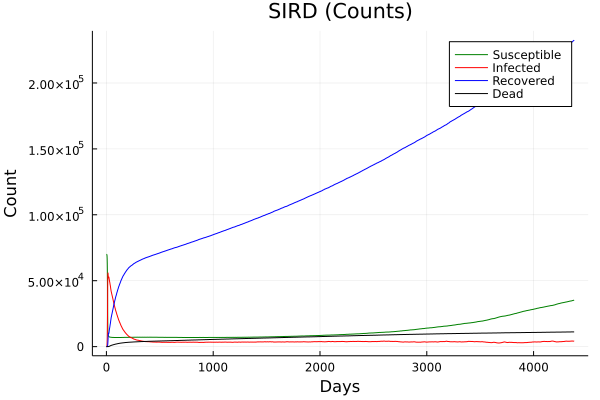

In [222]:
N = sum(model.N_total) # Total initial population
x = data.step
Plots.plot(x, (data[:, aggname(:status, length)].-data[:, aggname(:status, recovered)]
        .-data[:, aggname(:status, infected)]), color = :green,label="Susceptible",xlabel="Days",ylabel="Count", title="SIRD (Counts)")
Plots.plot!(x, (data[:, aggname(:status, infected)]), color = :red,label="Infected")
Plots.plot!(x, (data[:, aggname(:status, recovered)]), color = :blue,label="Recovered")
Plots.plot!(x, model.cumulative_deaths[1:length(x)], color = :black,label="Dead")

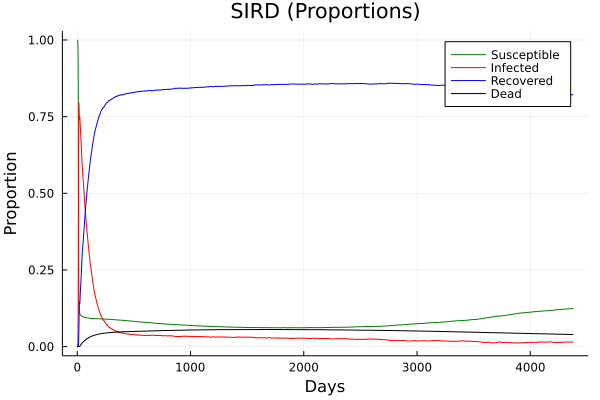

In [223]:
#Graph of proportions
x = data.step
total = data[:, aggname(:status, length)]+model.cumulative_deaths[1:length(x)]
Plots.plot(x, (data[:, aggname(:status, length)].-data[:, aggname(:status, recovered)]
        .-data[:, aggname(:status, infected)])./total, color = :green,label="Susceptible",xlabel="Days",ylabel="Proportion")
Plots.plot!(x, (data[:, aggname(:status, infected)])./total, color = :red,label="Infected",title="SIRD (Proportions)")
Plots.plot!(x, (data[:, aggname(:status, recovered)])./total, color = :blue,label="Recovered")
Plots.plot!(x, model.cumulative_deaths[1:length(x)]./total, color = :black,label="Dead")

In [ ]:
model.pop_by_state

In [281]:
model.total_ever_cases_per_state

Dict{String, Int64} with 36 entries:
  "andaman & nicobar islands"            => 6622
  "dadra & nagar haveli and daman & diu" => 888
  "chhattisgarh"                         => 1691
  "haryana"                              => 1602
  "manipur"                              => 857
  "assam"                                => 3831
  "meghalaya"                            => 2584
  "gujarat"                              => 4149
  "kerala"                               => 2205
  "goa"                                  => 1085
  "jammu & kashmir"                      => 1912
  "nagaland"                             => 1426
  "mizoram"                              => 1284
  "tamil nadu"                           => 1209
  "west bengal"                          => 3379
  "maharashtra"                          => 2558
  "andhra pradesh"                       => 5633
  "tripura"                              => 692642
  "chandigarh"                           => 1156
  "punjab"                      

In [263]:
prevalence_by_state= Dict{String,Float64}()

for state in keys(model.total_ever_cases_per_state)
    prevalence_by_state[state]=model.total_ever_cases_per_state[state]/model.pop_by_state[state]/(365*12)*mean(model.infection_duration)
end

In [244]:
model.total_ever_abx_per_state

Dict{String, Int64} with 36 entries:
  "andaman & nicobar islands"            => 6491
  "dadra & nagar haveli and daman & diu" => 1095
  "chhattisgarh"                         => 2042
  "haryana"                              => 2107
  "manipur"                              => 1119
  "assam"                                => 3497
  "meghalaya"                            => 3294
  "gujarat"                              => 4090
  "kerala"                               => 2179
  "goa"                                  => 1060
  "jammu & kashmir"                      => 2143
  "nagaland"                             => 1329
  "mizoram"                              => 1170
  "tamil nadu"                           => 1626
  "west bengal"                          => 3864
  "maharashtra"                          => 2609
  "andhra pradesh"                       => 7370
  "tripura"                              => 846916
  "chandigarh"                           => 1105
  "punjab"                    

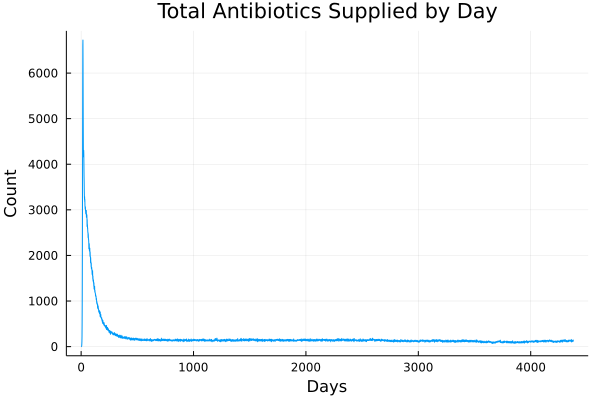

In [224]:
Plots.plot(x, model.antibiotics_by_day[1:length(x)],title="Total Antibiotics Supplied by Day",xlabel="Days",ylabel="Count",label="")

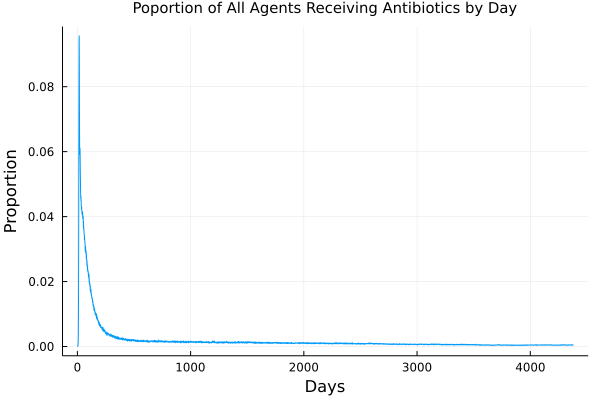

In [225]:
#graph of proportions
Plots.plot(x, model.antibiotics_by_day[1:length(x)]./total,title="Poportion of All Agents Receiving Antibiotics by Day",xlabel="Days",ylabel="Proportion",label="",titlefontsize=10)

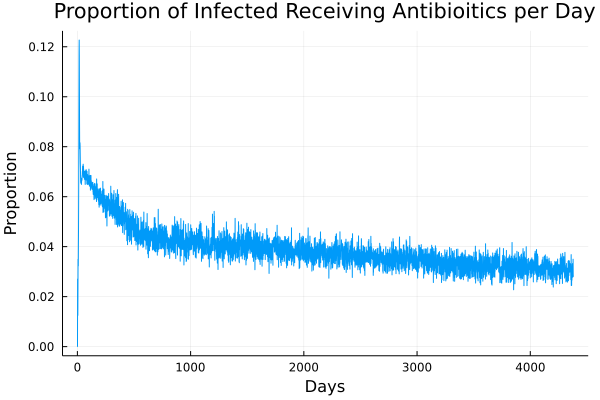

In [226]:
#graph of proportions per infected
Plots.plot(x, model.antibiotics_by_day[1:length(x)]./data[:, aggname(:status, infected)],title="Proportion of Infected Receiving Antibioitics per Day",xlabel="Days",ylabel="Proportion",label="")

In [227]:
print("Proportion of all infected at start that obtain antibiotics at least once: ", sum(model.antibiotics_by_day[1:9]./data[:, aggname(:status, infected)][1:9]))

Proportion of all infected at start that obtain antibiotics at least once: 0.18485815627259983

In [228]:
print("Proportion of total agents that are in wealth quintiles 1 and 2: ",(model.total_quintiles[1][1]+model.total_quintiles[2][1])/(model.total_quintiles[1][1]+model.total_quintiles[2][1]+model.total_quintiles[3][1]+model.total_quintiles[4][1]+model.total_quintiles[5][1]))

Proportion of total agents that are in wealth quintiles 1 and 2: 0.4529650597586779

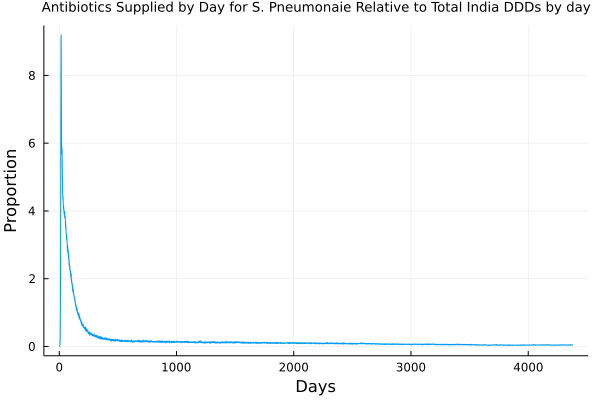

In [229]:
#graph of proportion of antibiotics to cover S. Pneumonaie relative to total abxs supplied (total = 10.4 DDDs per 1000 people per day)
Plots.plot(x, model.antibiotics_by_day[1:length(x)]./(model.total_quintiles[1].+model.total_quintiles[2].+model.total_quintiles[3].+model.total_quintiles[4].+model.total_quintiles[5]).*1000/10.4,
    title="Antibiotics Supplied by Day for S. Pneumonaie Relative to Total India DDDs by day",xlabel="Days",ylabel="Proportion",label="",titlefontsize=9)

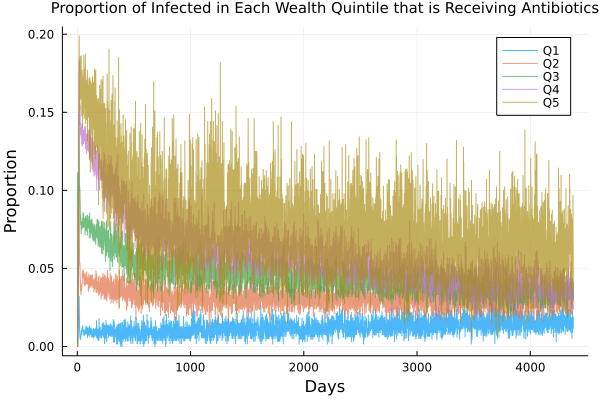

In [248]:
#Proportion of infected in each wealth quintile that is receiving antibiotics
x = data.step
Plots.plot(x, model.antibiotics_quintiles[1][1:length(x)]./model.infections_quintiles[1][1:length(x)],title="Proportion of Infected in Each Wealth Quintile that is Receiving Antibiotics",xlabel="Days",ylabel="Proportion",label="Q1",titlefontsize=10,alpha=0.7)
for quintile in 2:5
    p=Plots.plot!(x, model.antibiotics_quintiles[quintile][1:length(x)]./model.infections_quintiles[quintile][1:length(x)],label="Q"*string(quintile),alpha=0.7)
    
    if quintile==5
        display(p)
    end
end


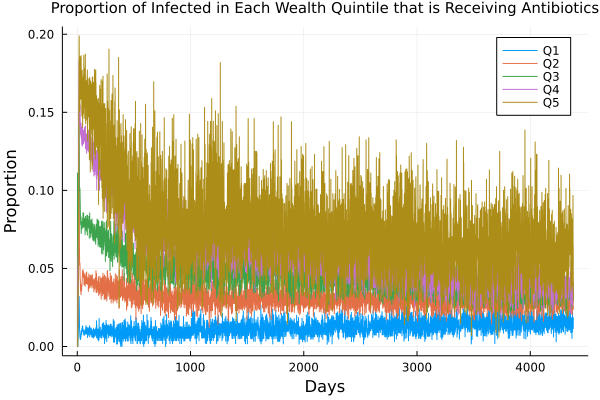

In [230]:
#Proportion of infected in each wealth quintile that is receiving antibiotics
x = data.step
Plots.plot(x, model.antibiotics_quintiles[1][1:length(x)]./model.infections_quintiles[1][1:length(x)],title="Proportion of Infected in Each Wealth Quintile that is Receiving Antibiotics",xlabel="Days",ylabel="Proportion",label="Q1",titlefontsize=10)
for quintile in 2:5
    p=Plots.plot!(x, model.antibiotics_quintiles[quintile][1:length(x)]./model.infections_quintiles[quintile][1:length(x)],label="Q"*string(quintile))
    
    if quintile==5
        display(p)
    end
end


#### To change total 'community transmitted cases', should adjust "contact_transmitted" factor

In [231]:
println(model.community_transmitted)
println(model.contact_transmitted)

114303
1307846


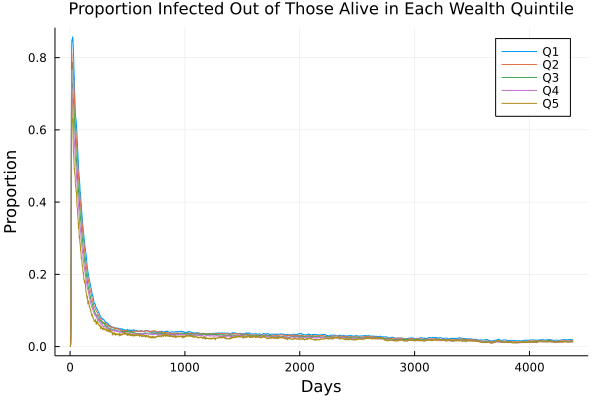

In [232]:
#Proportion of each wealth quintile comprised of infected
x = data.step
Plots.plot(x,model.infections_quintiles[1]./(model.total_quintiles[1].-model.cumulative_deaths_quintiles[1]),title="Proportion Infected Out of Those Alive in Each Wealth Quintile",xlabel="Days",ylabel="Proportion",label="Q1",titlefontsize=11)
for quintile in 2:5
    model.infections_quintiles[quintile]
    model.total_quintiles[quintile]
    p=Plots.plot!(x,model.infections_quintiles[quintile]./(model.total_quintiles[quintile].-model.cumulative_deaths_quintiles[quintile]),label="Q"*string(quintile))
    
    if quintile==5
        display(p)
    end
end

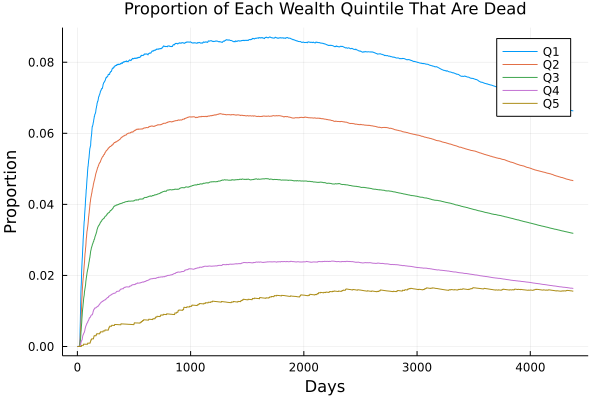

In [233]:
#Proportion of each wealth quintile comprised of dead

x = data.step
Plots.plot(x,model.cumulative_deaths_quintiles[1]./(model.total_quintiles[1].+model.cumulative_deaths_quintiles[1]),title="Proportion of Each Wealth Quintile That Are Dead",xlabel="Days",ylabel="Proportion",label="Q1",titlefontsize=11)
for quintile in 2:5
    model.cumulative_deaths_quintiles[quintile]
    model.total_quintiles[quintile]
    p=Plots.plot!(x,model.cumulative_deaths_quintiles[quintile]./(model.total_quintiles[quintile].+model.cumulative_deaths_quintiles[quintile]),label="Q"*string(quintile))
    if quintile==5
        display(p)
    end
end

### Below is not very informative (does not account for the differences in wealth quintile sizes)

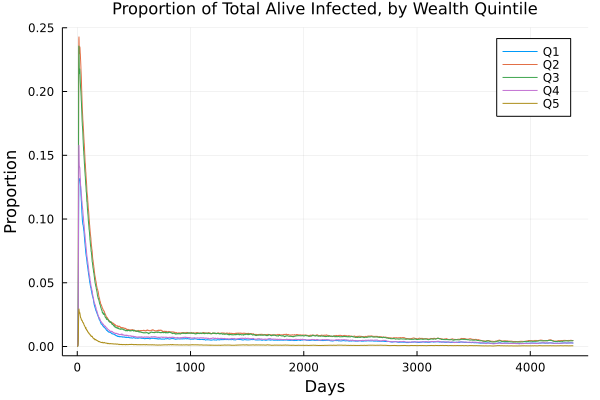

In [234]:
#proportion of total alive infected, by wealth quintile
x = data.step


total = sum([model.total_quintiles[i]-model.cumulative_deaths_quintiles[i] for i in 1:5])

Plots.plot(x,model.infections_quintiles[1]./total,title="Proportion of Total Alive Infected, by Wealth Quintile",xlabel="Days",ylabel="Proportion",label="Q1",titlefontsize=11)
for quintile in 2:5
    model.infections_quintiles[quintile]
    model.total_quintiles[quintile]
    p=Plots.plot!(x,model.infections_quintiles[quintile]./total,label="Q"*string(quintile))
    
    if quintile==5
        display(p)
    end
end

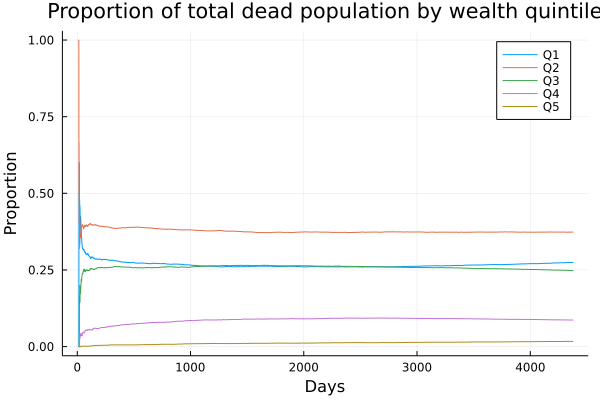

In [235]:
#Proportion of *total dead population* by wealth quintile
x = data.step
Plots.plot(x,model.cumulative_deaths_quintiles[1]./model.cumulative_deaths,title="Proportion of total dead population by wealth quintile",xlabel="Days",ylabel="Proportion",label="Q1")
for quintile in 2:5
    p=Plots.plot!(x,model.cumulative_deaths_quintiles[quintile]./model.cumulative_deaths,label="Q"*string(quintile))
    if quintile==5
        display(p)
    end
end